In [11]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [12]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


Allocate GPU

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Layer: 1-2                             --                        --                        --  

Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        A.augmentations.crops.transforms.CropAndPad(-4, p=0.5),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

100%|██████████| 170498071/170498071 [00:05<00:00, 29674169.20it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Show sample Images from the dataset

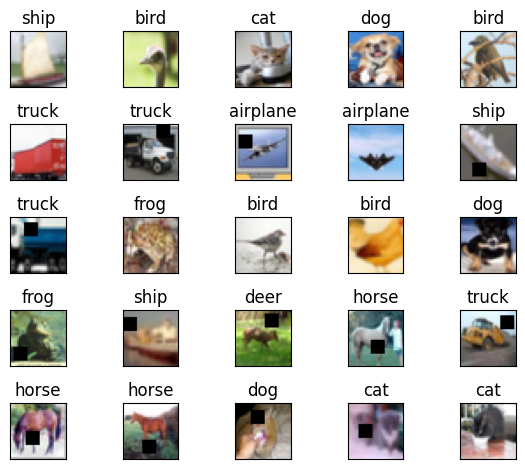

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


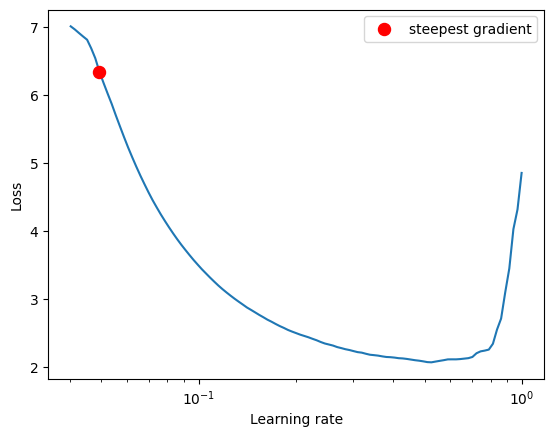

In [7]:
drop_out = 0.05
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10, drop_out_probability = drop_out).to(device)
criterion = nn.CrossEntropyLoss()
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [8]:
from torch.optim.lr_scheduler import OneCycleLR
#optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
def define_scheduler(max_lr):
    scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'#, verbose=True
        )
    return scheduler

max_lr = 4.93E-2
optim_obj.scheduler = define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()
    lr_values.append(optim_obj.optimizer.param_groups[0]['lr'])


epoch: 1


loss=1.253967046737671 batch_id=97 Accuracy = 42.84: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average loss: 0.0031, Accuracy: 4807/10000 (48.07%)

epoch: 2


loss=1.0297647714614868 batch_id=97 Accuracy = 58.26: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]



Test set: Average loss: 0.0021, Accuracy: 6506/10000 (65.06%)

epoch: 3


loss=0.9947194457054138 batch_id=97 Accuracy = 66.66: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]



Test set: Average loss: 0.0020, Accuracy: 6578/10000 (65.78%)

epoch: 4


loss=0.9308473467826843 batch_id=97 Accuracy = 71.00: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0027, Accuracy: 5600/10000 (56.00%)

epoch: 5


loss=0.8536631464958191 batch_id=97 Accuracy = 70.85: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0021, Accuracy: 6428/10000 (64.28%)

epoch: 6


loss=0.8541336059570312 batch_id=97 Accuracy = 71.04: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]



Test set: Average loss: 0.0025, Accuracy: 6021/10000 (60.21%)

epoch: 7


loss=0.9767088294029236 batch_id=97 Accuracy = 71.74: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]



Test set: Average loss: 0.0030, Accuracy: 5498/10000 (54.98%)

epoch: 8


loss=0.831672191619873 batch_id=97 Accuracy = 73.21: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]



Test set: Average loss: 0.0018, Accuracy: 7046/10000 (70.46%)

epoch: 9


loss=0.783765435218811 batch_id=97 Accuracy = 73.20: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.0018, Accuracy: 7000/10000 (70.00%)

epoch: 10


loss=0.7401130795478821 batch_id=97 Accuracy = 73.86: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.0014, Accuracy: 7553/10000 (75.53%)

epoch: 11


loss=0.8242249488830566 batch_id=97 Accuracy = 75.09: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0019, Accuracy: 6840/10000 (68.40%)

epoch: 12


loss=0.6557146310806274 batch_id=97 Accuracy = 75.47: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.0024, Accuracy: 6419/10000 (64.19%)

epoch: 13


loss=0.6171309351921082 batch_id=97 Accuracy = 75.67: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0018, Accuracy: 6875/10000 (68.75%)

epoch: 14


loss=0.528051495552063 batch_id=97 Accuracy = 76.48: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0014, Accuracy: 7616/10000 (76.16%)

epoch: 15


loss=0.6966374516487122 batch_id=97 Accuracy = 77.05: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0017, Accuracy: 7075/10000 (70.75%)

epoch: 16


loss=0.8041412830352783 batch_id=97 Accuracy = 78.42: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 0.0015, Accuracy: 7481/10000 (74.81%)

epoch: 17


loss=0.5303182005882263 batch_id=97 Accuracy = 79.20: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.0012, Accuracy: 7902/10000 (79.02%)

epoch: 18


loss=0.617678165435791 batch_id=97 Accuracy = 79.91: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 0.0013, Accuracy: 7836/10000 (78.36%)

epoch: 19


loss=0.4948938488960266 batch_id=97 Accuracy = 80.81: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.0013, Accuracy: 7792/10000 (77.92%)

epoch: 20


loss=0.4914079010486603 batch_id=97 Accuracy = 82.27: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]



Test set: Average loss: 0.0013, Accuracy: 7850/10000 (78.50%)

epoch: 21


loss=0.4893445074558258 batch_id=97 Accuracy = 83.76: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 0.0010, Accuracy: 8313/10000 (83.13%)

epoch: 22


loss=0.40174785256385803 batch_id=97 Accuracy = 85.67: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.0008, Accuracy: 8578/10000 (85.78%)

epoch: 23


loss=0.3270896077156067 batch_id=97 Accuracy = 88.02: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 0.0007, Accuracy: 8733/10000 (87.33%)

epoch: 24


loss=0.3671562373638153 batch_id=97 Accuracy = 90.35: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]



Test set: Average loss: 0.0007, Accuracy: 8850/10000 (88.50%)



Plot LR values

In [9]:
import matplotlib.pyplot as plt
def plot_lr_values(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    plt.yscale('log')
    plt.show()

Plot results for Batch Norm experiment

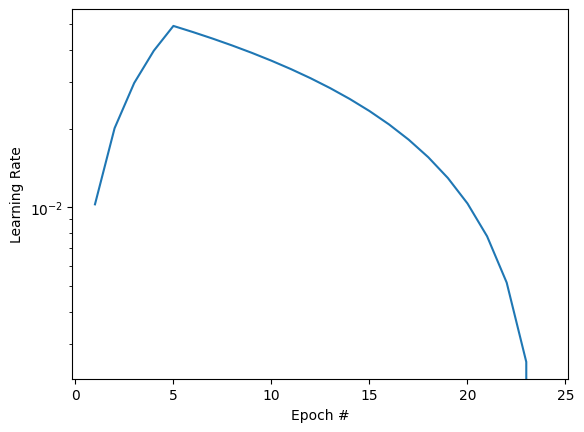

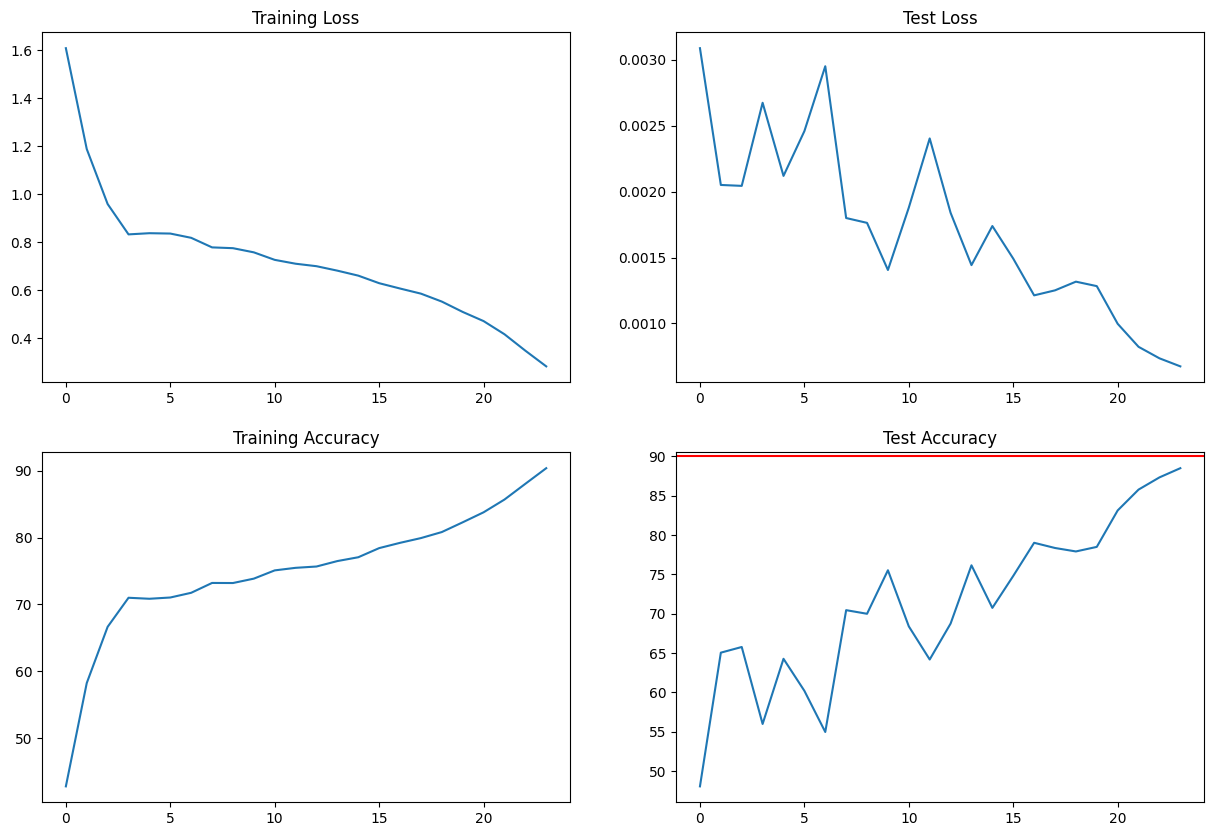

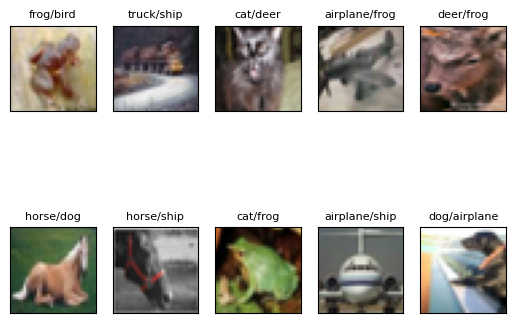

[0.010274361963190183, 0.020055723926380366, 0.02983708588957055, 0.03961844785276073, 0.04927352574113856, 0.0466790483727175, 0.044084571004296455, 0.0414900936358754, 0.038895616267454344, 0.036301138899033296, 0.03370666153061224, 0.03111218416219119, 0.028517706793770137, 0.025923229425349085, 0.023328752056928033, 0.020734274688506985, 0.01813979732008593, 0.015545319951664874, 0.012950842583243825, 0.01035636521482277, 0.007761887846401722, 0.005167410477980666, 0.002572933109559611, -2.154425886143757e-05]


In [10]:
plot_lr_values(lr_values)
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc=90.)
incorrect_predictions_bn = get_incorrect_predictions(resnet_model, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)
print(lr_values)

Print Training Log

In [14]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.6086547654502246 | 0.0030871936082839968 |     42.836     |    48.07     |
|   2   |  1.1880385431708123 | 0.0020502446711063386 |     58.264     |    65.06     |
|   3   |  0.9586365454050959 |  0.002043340849876404 |     66.662     |    65.78     |
|   4   |  0.832024563940204  |  0.002673268294334412 |     71.002     |     56.0     |
|   5   |  0.8369645701379193 | 0.0021188780426979067 |     70.852     |    64.28     |
|   6   |  0.8354941965365896 |  0.002458297896385193 |     71.04      |    60.21     |
|   7   |  0.8176926429174385 | 0.0029503366827964782 |     71.744     |    54.98     |
|   8   |  0.7778066159511099 | 0.0017995050966739656 |     73.214     |    70.46     |
|   9   |  0.7745091203524141 | 